In [1]:
import numpy as np
import os
import PIL
import tensorflow as tf
import glob
import pathlib
import matplotlib.pyplot as plt
import cv2

from PIL import Image
from tensorflow import keras
from tensorflow.keras import datasets, layers, models

In [2]:
print(tf.__version__)

2.5.0


In [3]:
#data 폴더 불러옴
data_dir = pathlib.Path('data/')
data_jpg = data_dir.glob('*/*.jpg')
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

1709


In [4]:
#불러온 이미지 검사
def check_images( s_dir, ext_list):
    bad_images=[]
    bad_ext=[]
    s_list= os.listdir(s_dir)
    for klass in s_list:
        klass_path=os.path.join (s_dir, klass)
        print ('폴더 검색중 ', klass)
        if os.path.isdir(klass_path):
            file_list=os.listdir(klass_path)
            for f in file_list:               
                f_path=os.path.join (klass_path,f)
                index=f.rfind('.')
                ext=f[index+1:].lower()
                if ext not in ext_list:
                    print('발견 : 이미지 경로_', f_path, ' 잘못됨 ', ext)
                    bad_ext.append(f_path)
                if os.path.isfile(f_path):
                    try:
                        img=cv2.imread(f_path)
                        shape=img.shape
                    except:
                        print('발견 : 이미지 경로_', f_path, ' 올바른 이미지 파일 아님')
                        bad_images.append(f_path)
                else:
                    print('오류 폴더 경로 다시 지정')
        else:
            print ('최하위 폴더입니다. 상위 폴더를 지정해주세요.')
    return bad_images, bad_ext

source_dir = data_dir
good_exts=['jpg'] # 허용 이미지 리스트
bad_file_list, bad_ext_list=check_images(source_dir, good_exts)
if len(bad_file_list) !=0:
    print(' 오류 이미지 ')
    for i in range (len(bad_file_list)):
        print (bad_file_list[i])
else:
    print(' 잘못된 이미지 없음 ')

폴더 검색중  drink can
폴더 검색중  glassbottle_brown
폴더 검색중  glassbottle_green
폴더 검색중  glassbottle_white
폴더 검색중  plastic bottle
 잘못된 이미지 없음 


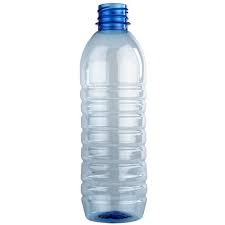

In [5]:
#플라스틱 병 폴더를 이용하여 잘 로드되었나 확인
plastic_bottle = list(data_dir.glob("plastic bottle/*.jpg"))
PIL.Image.open(str(plastic_bottle[0]))

In [6]:
#학습데이터
train = tf.keras.preprocessing.image_dataset_from_directory(data_dir,validation_split=0.2,subset="training",seed=123,
                                                            image_size=(120, 120))
validation = tf.keras.preprocessing.image_dataset_from_directory(data_dir,validation_split=0.2,subset="validation",seed=123,
                                                            image_size=(120, 120))

Found 1709 files belonging to 5 classes.
Using 1368 files for training.
Found 1709 files belonging to 5 classes.
Using 341 files for validation.


In [7]:
#클래스명 확인
class_names = train.class_names
print(class_names)

['drink can', 'glassbottle_brown', 'glassbottle_green', 'glassbottle_white', 'plastic bottle']


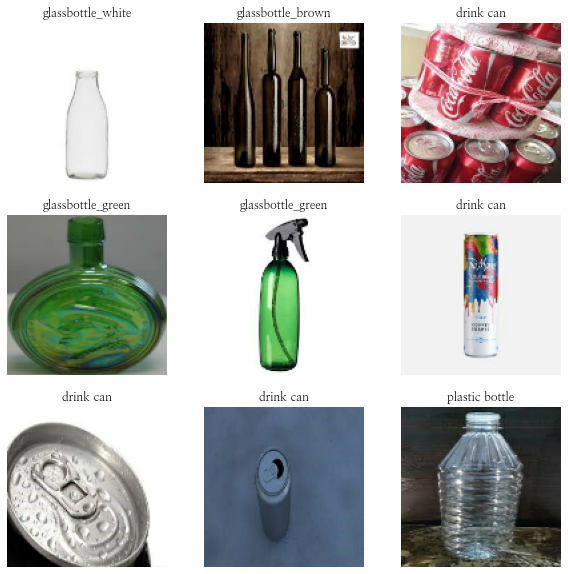

In [22]:
#클래스명 : 이미지 출력
plt.figure(figsize=(10,10))
for images, labels in train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [9]:
for image_batch, labels_batch in train:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 120, 120, 3)
(32,)


120 * 120 * 3 형상의 이미지 32묶음

In [10]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [11]:
#표준화
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [12]:
#표준화 2 - 텐서플로우 듀토리얼 참고
normalized_ds = train.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [13]:
#데이터 증강
data_augm = keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal",input_shape=(120,120,3)),
])

In [14]:
num_classes = len(class_names)

#CNN모델
model = Sequential([
    data_augm,
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(120, 120, 3)),
    layers.Conv2D(32, 11, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 5, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.Conv2D(128, 3, activation='relu'),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dropout(0.3),
    layers.Dense(256, activation='relu'),
    layers.Dense(num_classes)
])

In [15]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 120, 120, 3)       0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 120, 120, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 110, 110, 32)      11648     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 55, 55, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 51, 51, 64)        51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 23, 23, 128)      

In [17]:
#훈련
history = model.fit(train, validation_data=validation,epochs=8)

Epoch 1/8
43/43 [==============================] - 25s 559ms/step - loss: 1.5158 - accuracy: 0.2975 - val_loss: 1.3441 - val_accuracy: 0.4340
Epoch 2/8
43/43 [==============================] - 24s 550ms/step - loss: 1.3627 - accuracy: 0.3860 - val_loss: 1.2938 - val_accuracy: 0.3842
Epoch 3/8
43/43 [==============================] - 24s 565ms/step - loss: 1.2300 - accuracy: 0.4518 - val_loss: 1.1623 - val_accuracy: 0.4839
Epoch 4/8
43/43 [==============================] - 23s 534ms/step - loss: 1.0967 - accuracy: 0.5146 - val_loss: 1.2016 - val_accuracy: 0.5044
Epoch 5/8
43/43 [==============================] - 23s 539ms/step - loss: 1.0671 - accuracy: 0.5512 - val_loss: 1.1233 - val_accuracy: 0.5161
Epoch 6/8
43/43 [==============================] - 23s 539ms/step - loss: 1.0508 - accuracy: 0.5504 - val_loss: 1.1926 - val_accuracy: 0.5396
Epoch 7/8
43/43 [==============================] - 23s 533ms/step - loss: 1.0072 - accuracy: 0.5899 - val_loss: 1.0620 - val_accuracy: 0.5337
Epoch 

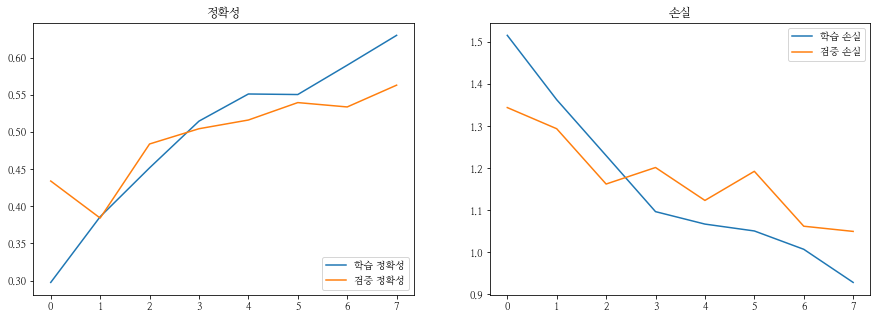

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(8)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='학습 정확성')
plt.plot(epochs_range, val_acc, label='검증 정확성')
plt.legend(loc='lower right')
plt.title('정확성')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='학습 손실')
plt.plot(epochs_range, val_loss, label='검증 손실')
plt.legend(loc='upper right')
plt.title('손실')
plt.show()

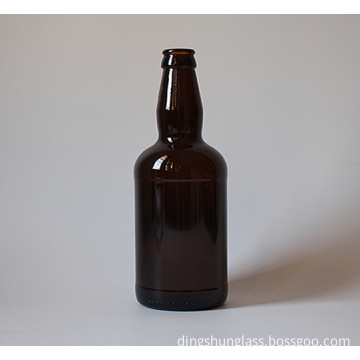

In [19]:
test_img=pathlib.Path('test/5.jpg')
PIL.Image.open(test_img)

In [20]:
#이미지 예측
img = keras.preprocessing.image.load_img(test_img, target_size=(120, 120))
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "이 이미지는 {} ( {:.2f} % )(으)로 예측됩니다."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

이 이미지는 glassbottle_brown ( 76.21 % )(으)로 예측됩니다.
